### IMPORTS

In [1]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *
import math

In [2]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# primary net
nb_neurons_pn=50
activation_pn=nn.Tanh()
param_count=3*nb_neurons_pn+1


lat_dim=1 #number of latent dimensions of the hypernets ("noise" dimension)
nb_neurons=param_count #layerwidth hypernet (default is dimension of output)
activation=nn.ReLU() #activation function of hypernet
nb_comp=2 #ensemble_size, number of hypernets to train in the ensemble
init_w=.2 #std for weight initialization of output layers
init_b=.001 #std for bias initialization of output layers

n_samples_KDE=1000 #number of samples for KDE (Kernel Density Estimation)
KDE_prec=1. #factor reducing Silverman's bandwidth for KDE
n_samples_ED=10 #number of samples for MC estimation of differential entropy (using KDE)
n_samples_LP=10 #number of samples for MC estimation of expected logposterior
n_samples_KNN=1000 #number of samples for KNN (nearest neighbour entropy estimate)


# Load data #

In [4]:
# load data and make it in proper shape
data = torch.load('Experiments/Foong_L1W50/Data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)
x_data.shape



torch.Size([200, 1])

# Calcul du posterior sur les paramètres principaux #

À chaque paramètre $\theta\in \mathbb{R}^{61}$ correspond un prédicteur $f_\theta:\mathbb{R}\to \mathbb{R}$. Le postérieur sur les paramètres principaux est défini comme:
$$
P(\theta | \text{data})=P(\theta)P(\text{data}|\theta)
$$
où $P(\theta)$ est un prior $N(0,I)$ et le likelihood est donné par
$$
P(\text{data}|\theta)=\prod_{(x,y)\in\text{data}}P(y|f_\theta(x),0.1)
$$
où $P(y|f_\theta(x),\sigma)$ la fonction de densité de la loi normale de moyenne $f_\theta(x)$ et d'écart-type $0.1$ (qui correspond au bruit utilisé pour générer les données).

In [5]:
#Prior
prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(param_count),torch.eye(param_count))

def logprior(theta):
    return prior.log_prob(theta).unsqueeze(-1)

def log_norm(y,y_,std):
    point_estimate= torch.distributions.normal.Normal(y_, std)
    return point_estimate.log_prob(y)

# likelihood of the parameters


def loglikelihood(theta):
    y_pred = Net(theta,x_data)
    L = log_norm(y_pred, y_data, .1)
    return torch.sum(L,1)


def logposterior(theta):
    return logprior(theta).add(loglikelihood(theta))


# Primary Net (Predictive Net) #

In [6]:
class Parallel_Net(nn.Module):
    def __init__(self, nb_neur,activation):
        super(Parallel_Net, self).__init__()
        self.nb_neur = nb_neur 
        self.activation=activation
        self.requires_grad_(False)
        self.param_count=3*nb_neur+1
        
    def forward(self,theta,x):
        nb_theta=theta.shape[0]
        theta=theta.split([self.nb_neur,self.nb_neur,self.nb_neur,1],dim=1)
        nb_x=x.shape[0]
        input_x=x.view(nb_x,1,1)
        m1=torch.matmul(theta[0].view(nb_theta,1,self.nb_neur,1),input_x)
        m2=m1.add(theta[1].reshape(nb_theta,1,self.nb_neur,1))
        m3=self.activation(m2)
        m4=torch.matmul(theta[2].view(nb_theta,1,1,self.nb_neur),m3)
        m5=m4.add(theta[3].reshape(nb_theta,1,1,1))
        return m5.squeeze(-1)

In [7]:
Net=Parallel_Net(nb_neurons_pn,activation_pn)

# Hyper Net #

In [8]:
class Transformer(nn.Module):
    def __init__(self, lat_dim=5,nb_neur=nb_neurons,output_dim=param_count, layers=1, activation=nn.ReLU()):
        super(Transformer, self).__init__()
        self.lat_dim = lat_dim
        self.output_dim=output_dim
        if layers==1:
            self.hnet=nn.Sequential(
                nn.Linear(lat_dim,nb_neur),
                activation,
                nn.Linear(nb_neur,output_dim)
                )
        if layers==2:
            self.hnet=nn.Sequential(
                nn.Linear(lat_dim,nb_neur),
                activation,
                nn.Linear(nb_neur,nb_neur),
                activation,
                nn.Linear(nb_neur,output_dim)
                )
        if layers==3:
            self.hnet=nn.Sequential(
                nn.Linear(lat_dim,nb_neur),
                activation,
                nn.Linear(nb_neur,nb_neur),
                activation,
                nn.Linear(nb_neur,nb_neur),
                activation,
                nn.Linear(nb_neur,output_dim)
                )
        self.hnet[2*layers].apply(init_weightsOut)

    
    def forward(self, n=1):
        epsilon = torch.randn(size=(n,self.lat_dim))
        return self.hnet(epsilon)

In [9]:
def init_weightsOut(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight,mean=0., std=init_w)
            torch.nn.init.normal_(m.bias,mean=0., std=init_b)

In [10]:
class HyNetEns(nn.Module):
    def __init__(self,nb_comp, output_dim):
        super(HyNetEns, self).__init__()
        self.nb_comp=nb_comp
        self.output_dim=output_dim
        self.components= nn.ModuleList([Transformer() for i in range(nb_comp)])   

 
    # "Silverman's rule of thumb", Wand and Jones p.111 "Kernel Smoothing" 1995.                                 
    def get_H(self, nb_samples):
        theta=self.sample(nb_samples)
        c_=(nb_samples*(self.output_dim+2))/4
        c=torch.as_tensor(c_).pow(2/(self.output_dim+4)).to(device)      
        H_=theta.var(1)/c
        #H_=theta.var(1).min(1).values/c*torch.ones(self.output_dim) #to try!
        return theta, H_.clamp(torch.finfo().eps,float('inf'))

    def KDE(self, theta_,theta, H_):
        def kernel(theta1,theta2,H):
            mvn = torch.distributions.multivariate_normal.MultivariateNormal(theta1, torch.diag(H))
            return mvn.log_prob(theta2)
        LQ=torch.Tensor(theta_.shape[0],self.nb_comp,theta.shape[1]).to(device) 
        for c in range(self.nb_comp):
            for i in range(theta_.shape[0]):
                LQ[i,c]=kernel(theta_[i],theta[c],H_[c])
        N_=self.nb_comp*theta.shape[1]
        N=torch.as_tensor(float(N_)).to(device)
        return (LQ.logsumexp(2).logsumexp(1)-torch.log(N)).unsqueeze(1)

    def KNNE(self,nb_samples,k=1):  
        theta=self.forward(nb_samples)
        D=torch.cdist(theta,theta)
        a = torch.topk(D, k=k+1, dim=0, largest=False, sorted=True)[0][k].clamp(torch.finfo().eps,float('inf'))
        d=torch.as_tensor(float(self.output_dim)).to(device)
        K=torch.as_tensor(float(k)).to(device)
        N=torch.as_tensor(float(nb_samples)).to(device)
        lcd = (d/2.0*torch.log(torch.as_tensor(math.pi,device=device))) - torch.lgamma(1. + d/2.0)
        return torch.digamma(N) - torch.digamma(K) + lcd + d/nb_samples*torch.sum(torch.log(a))
  
    
    def KNNEp(self,nb_samples_KNN,nb_samples=1,k=1):
        x=self(nb_samples)
        samples=self(nb_samples_KNN)
        d=self.output_dim
        D=torch.cdist(x,samples)
        a = D.min()
        lcd = (d/2.0*torch.log(torch.tensor(math.pi))) - torch.lgamma(torch.tensor(1.0 + d/2.0))
        return - torch.digamma(torch.tensor(k).float()).double() + lcd + d*torch.log(a)      

    def sample(self, n=1):
        return torch.stack([self.components[c](n) for c in range(self.nb_comp)])

    
    def forward(self, n=1):
        return torch.cat([self.components[c](n).squeeze(0) for c in range(self.nb_comp)],dim=0)



In [11]:
Hyper_Nets=HyNetEns(nb_comp, param_count)

# Visualisation de l'initialisation #

<IPython.core.display.Javascript object>


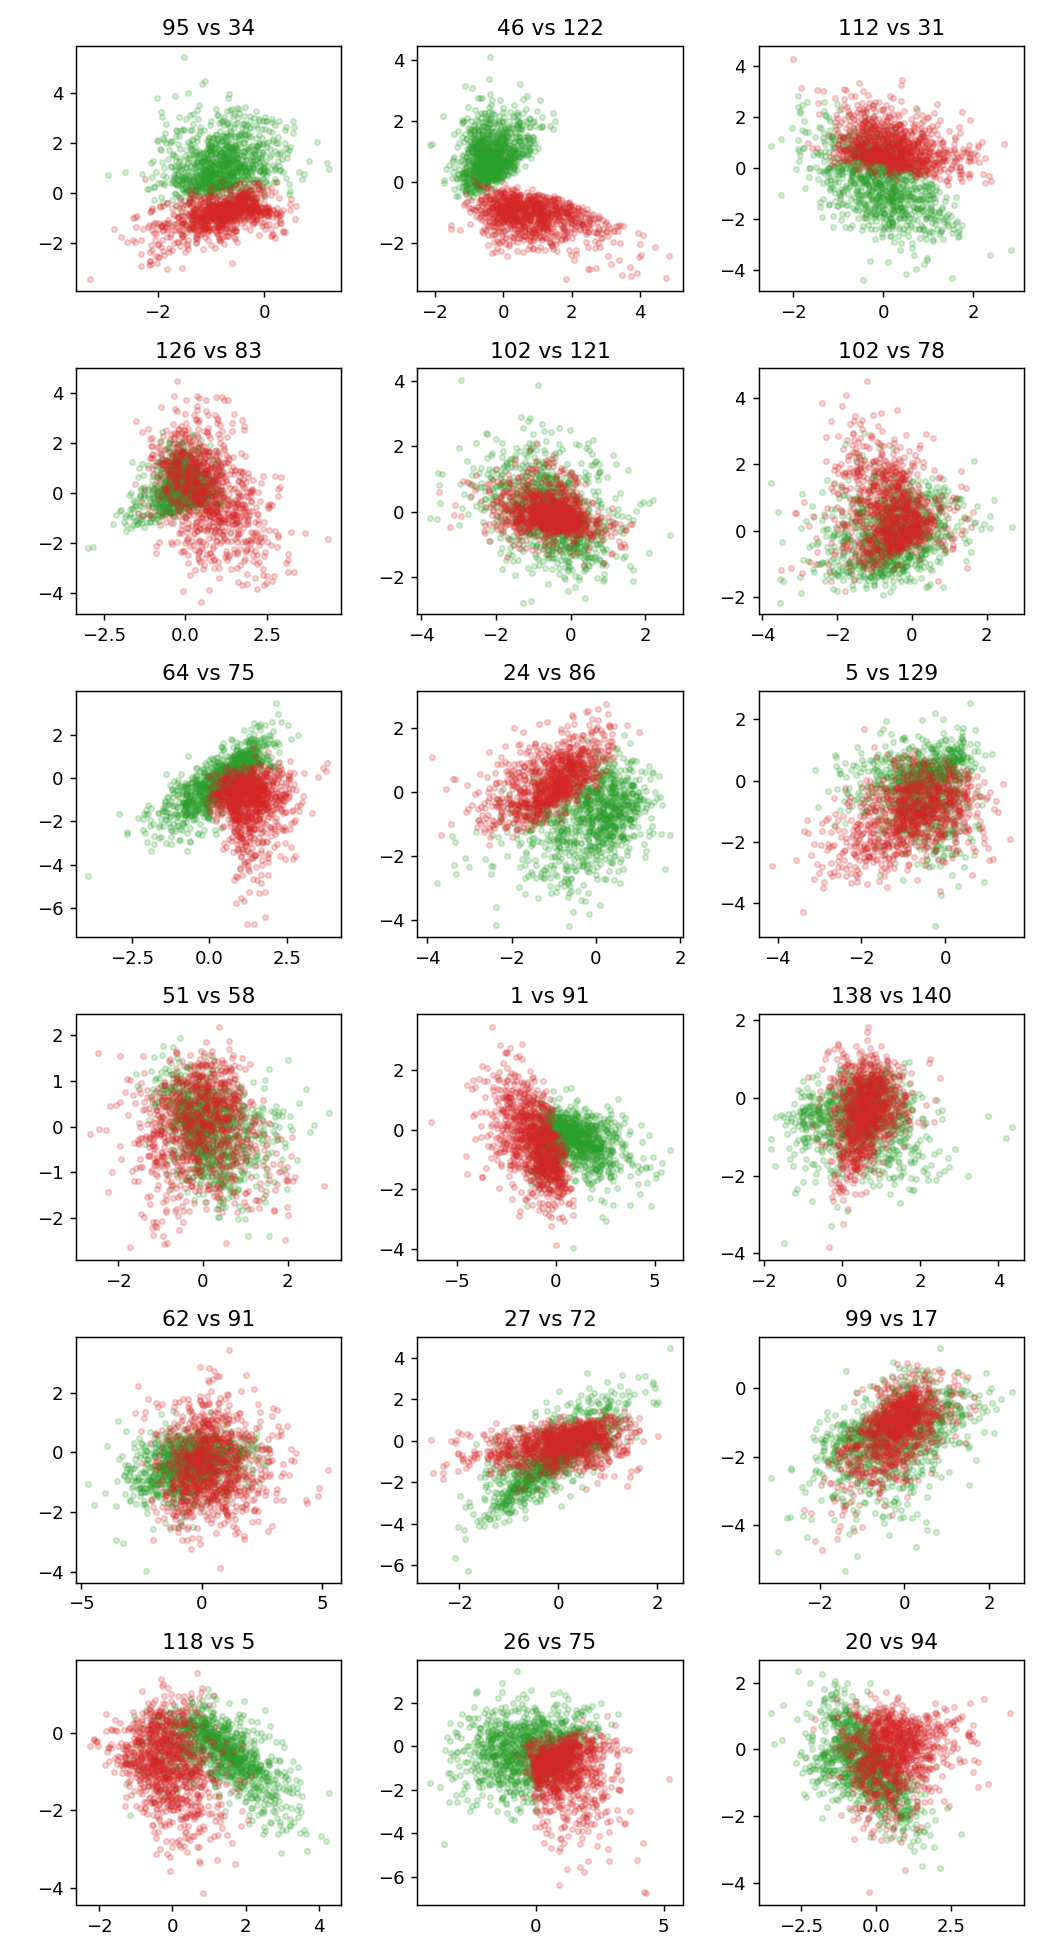

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook

theta =Hyper_Nets.sample(1000).detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
        for c in range(Hyper_Nets.nb_comp):
            axs[k, l].scatter(theta[c,:,i[0]],theta[c,:,i[1]],marker='.',alpha=0.2,color='C'+str(c+2))
        

fig.tight_layout()

<IPython.core.display.Javascript object>


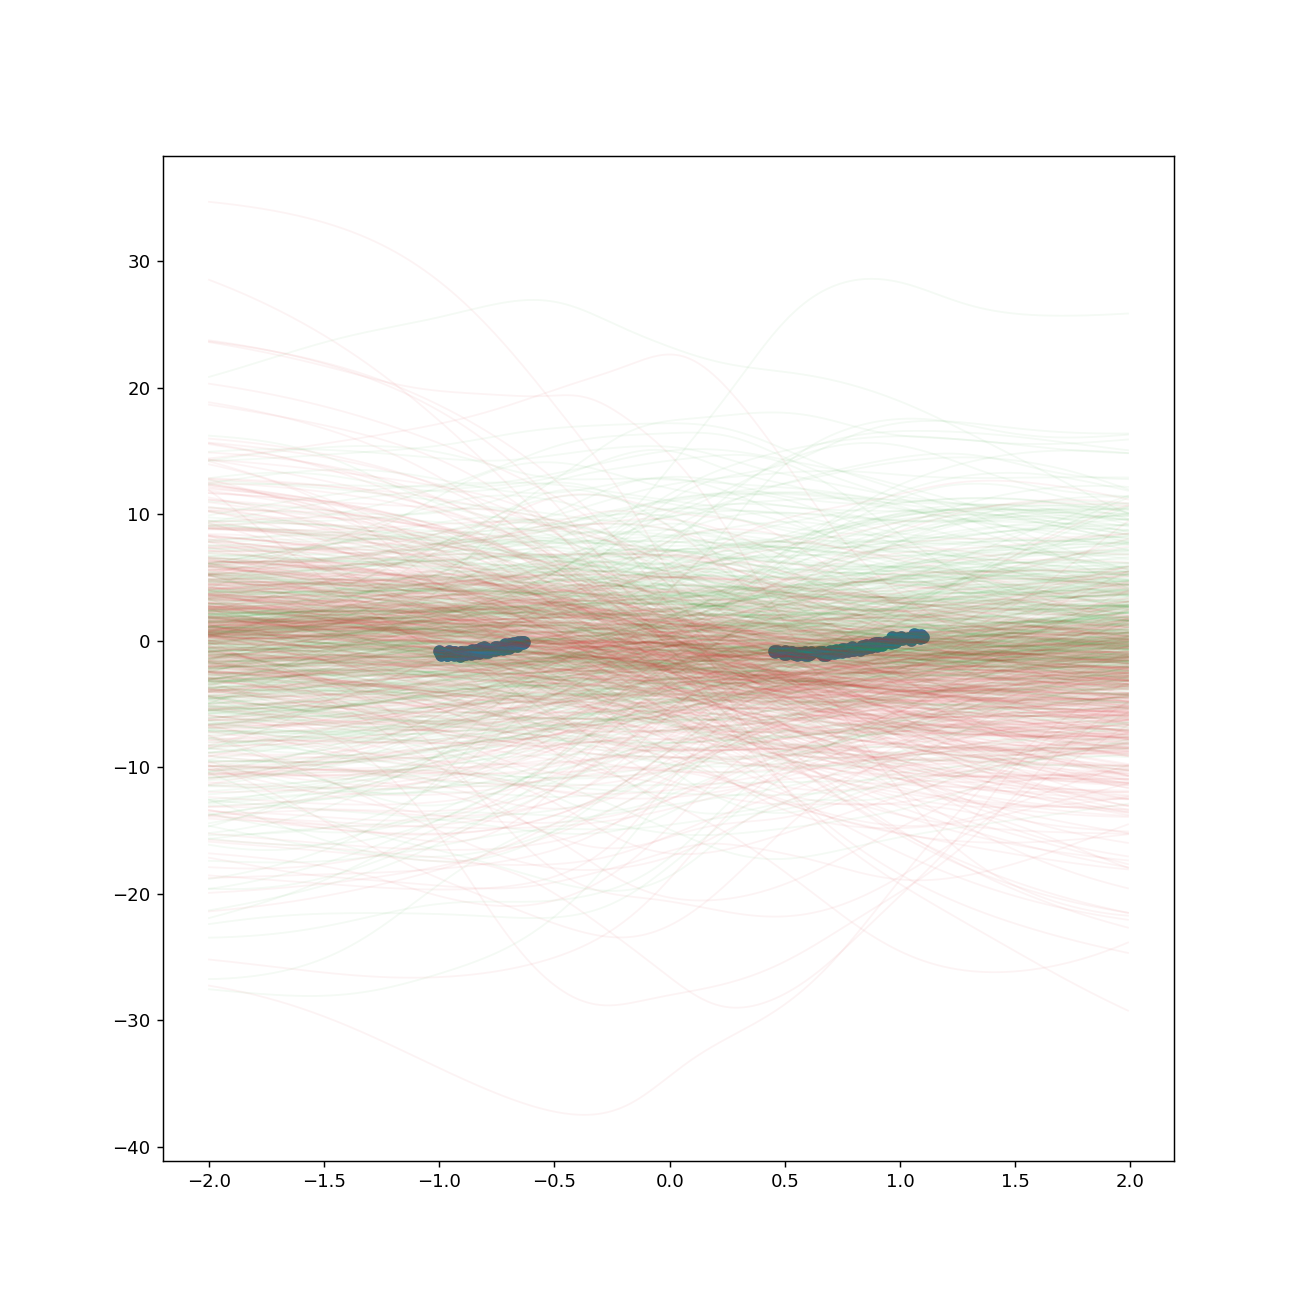

In [66]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

x_test = torch.arange(-2.,2.0,.01).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
#plt.title('Prior')
#ax.set_ylim(-4,4)

plt.scatter(x_data.cpu(), y_data.cpu())

nb_samples_plt=500
theta = Hyper_Nets.sample(nb_samples_plt).detach()
for c in range(Hyper_Nets.nb_comp):
    for i in range(nb_samples_plt):
        y_test = Net(theta[c,i].unsqueeze(0),x_test)
    #    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='green')
        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='C'+str(c+2))
    

In [14]:
GNN_optimizer = torch.optim.Adam(Hyper_Nets.parameters(), lr=.005)


In [15]:
GNN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(GNN_optimizer, patience=100, factor=0.5)


In [19]:
%matplotlib inline
liveloss = PlotLosses()

2

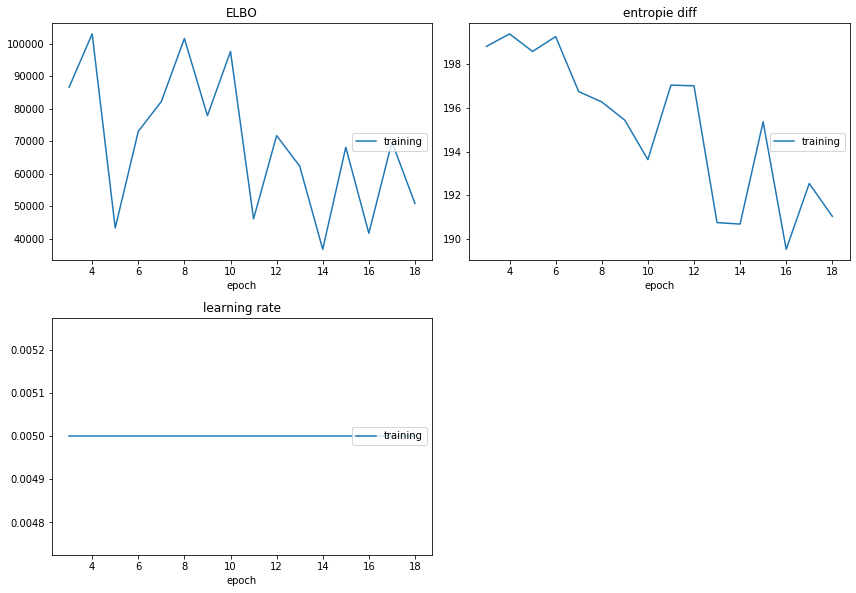

ELBO:
training   (min: 36825.270, max: 103015.391, cur: 50915.055)

entropie diff:
training   (min:  189.515, max:  199.394, cur:  191.028)

learning rate:
training   (min:    0.005, max:    0.005, cur:    0.005)


KeyboardInterrupt: 

In [21]:
%matplotlib inline
for t in range(10000):
    logs = {}
    GNN_optimizer.zero_grad()

    learning_rate = GNN_optimizer.param_groups[0]['lr']
    
#KDE
#    theta,H=Hyper_Nets.get_H(n_samples_KDE)
#    ED=-Hyper_Nets.KDE(Hyper_Nets(n_samples_ED),theta,KDE_prec*H).mean()

#KNN
    ED=Hyper_Nets.KNNE(n_samples_KNN, k=1)
 
#KNNp
#    ED=Hyper_Nets.KNNE(n_samples_KNN,20)
    LP=logposterior(Hyper_Nets(n_samples_LP)).mean()

    L =-ED-LP

    L.backward()
    

    

    GNN_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['entropie diff'] = ED.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)

   
    
    if t % 1 == 0:
        liveloss.draw()

    GNN_optimizer.step()


    if learning_rate < 0.0000001:
        break

In [24]:
theta=Hyper_Nets(1000)
theta.shape

torch.Size([2000, 151])

In [29]:
y_pred = Net(theta,x_data)
y_pred.shape

torch.Size([2000, 200, 1])

In [34]:
L = log_norm(y_pred, y_data, torch.tensor([.1],device=device))
L.shape

torch.Size([2000, 200, 1])

In [36]:
loglikelihood=torch.sum(L,1)
loglikelihood.shape

torch.Size([2000, 1])

In [38]:
loglikelihood.logsumexp(0)

tensor([-1448.4498], grad_fn=<LogsumexpBackward>)

In [40]:
theta.shape[0],torch.tensor(float(theta.shape[0])).log()

(2000, tensor(7.6009))

In [42]:
loglikelihood.logsumexp(0)-torch.tensor(float(theta.shape[0])).log()


tensor([-1456.0508], grad_fn=<SubBackward0>)

In [43]:
torch.as_tensor(float(theta.shape[0]),device=device).log()

tensor(7.6009)

FileNotFoundError: [Errno 2] No such file or directory: 'mlruns/2/a8f5b6ba5f4c47ea848d1e249385e524/artifacts/hypernets.pt'